In [1]:
import os
import torch
import numpy as np
from datetime import datetime

from faster_rcnn import network
from faster_rcnn.faster_rcnn import FasterRCNN, RPN
from faster_rcnn.utils.timer import Timer

import faster_rcnn.roi_data_layer.roidb as rdl_roidb
from faster_rcnn.roi_data_layer.layer import RoIDataLayer
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file

from faster_rcnn.pose_net import PoseNet

try:
    from termcolor import cprint
except ImportError:
    cprint = None

try:
    from pycrayon import CrayonClient
except ImportError:
    CrayonClient = None


def log_print(text, color=None, on_color=None, attrs=None):
    if cprint is not None:
        cprint(text, color=color, on_color=on_color, attrs=attrs)
    else:
        print(text)

In [2]:
# hyper-parameters
# ------------
#imdb_name = 'voc_2007_trainval'
imdb_name = 'kittipose_train'
cfg_file = 'experiments/cfgs/faster_rcnn_end2end.yml'
pretrained_model = '/home/pculbert/Documents/faster_rcnn_pytorch/VGG_imagenet.npy'
trained_fast_rcnn = 'models/saved_model9/faster_rcnn_100000.h5'
output_dir = 'trained_models/saved_pose_model2'

start_step = 0
end_step = 80000
lr_decay_steps = {40000, 60000}
lr_decay = 1./10

rand_seed = 1024
_DEBUG = True
use_tensorboard = False
remove_all_log = False   # remove all historical experiments in TensorBoard
exp_name = None # the previous experiment name in TensorBoard

# ------------

if rand_seed is not None:
    np.random.seed(rand_seed)

In [3]:
# load config
cfg_from_file(cfg_file)
lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY
disp_interval = cfg.TRAIN.DISPLAY
log_interval = cfg.TRAIN.LOG_IMAGE_ITERS

In [4]:
# load data
imdb = get_imdb(imdb_name)
rdl_roidb.prepare_roidb(imdb)
roidb = imdb.roidb
# roidb is a database, containing bounding box info for all training images
data_layer = RoIDataLayer(roidb, imdb.num_classes)

<bound method kittipose.default_roidb of <faster_rcnn.datasets.kittipose.kittipose object at 0x7f819c45ed90>>
Remove empty annotations:  Done. 
kittipose_val gt roidb loaded from /home/zjwang/git/faster_rcnn_pytorch/data/cache/kittipose_val_gt_roidb.pkl


In [5]:
# load net
net = PoseNet(classes=imdb.classes, debug=_DEBUG)
network.weights_normal_init(net, dev=0.01)
# network.load_pretrained_npy(net, pretrained_model)
network.load_net(trained_fast_rcnn, net.frcnn)
print('load model successfully!')

# model_file = '/media/longc/Data/models/VGGnet_fast_rcnn_iter_70000.h5'
# model_file = 'models/saved_model3/faster_rcnn_60000.h5'
# network.load_net(model_file, net)
# exp_name = 'vgg16_02-19_13-24'
# start_step = 60001
#lr /= 10.
# network.weights_normal_init([net.bbox_fc, net.score_fc, net.fc6, net.fc7], dev=0.01)

net.cuda()
net.train();

load model successfully!


In [6]:
#for name, param in net.named_parameters():
#    if param.requires_grad:
#        print name, param.data

In [7]:
#print list(net.parameters())[-4:]

In [8]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), 
                            lr=lr, momentum=momentum, weight_decay=weight_decay)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# tensorboad
use_tensorboard = use_tensorboard and CrayonClient is not None
if use_tensorboard:
    cc = CrayonClient(hostname='127.0.0.1')
    if remove_all_log:
        cc.remove_all_experiments()
    if exp_name is None:
        exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
        exp = cc.create_experiment(exp_name)
    else:
        exp = cc.open_experiment(exp_name)
        
#for param in net.parameters():
#    print(type(param.data), param.size())

In [ ]:
file_loss_pose = open(output_dir+'/loss_pose.txt', 'w')

train_loss = 0.
tp, tf, fg, bg = 0., 0., 0., 0.
step_cnt = 0.
re_cnt = False
t = Timer()
t.tic()
for step in range(start_step, end_step+1):
#for step in range(20):

    # get one batch
    blobs = data_layer.forward()
    im_data = blobs['data'] # one image, shape = (1, H, W, 3)
    im_info = blobs['im_info'] # stores H, W, scale
    gt_boxes = blobs['gt_boxes'] # groundtruth boxes
    gt_poses = blobs['gt_poses']
    gt_ishard = blobs['gt_ishard']
    dontcare_areas = blobs['dontcare_areas']
    dontcare_poses = blobs['dontcare_poses']
    disp_data = blobs['data_disp'] # disparity map

    # forward
    net(im_data, im_info, disp_data, gt_boxes, gt_poses, gt_ishard, dontcare_areas, dontcare_poses)
    loss = net.loss

    
    if _DEBUG:
        tp += float(net.tp)
        tf += float(net.tf)
        fg += net.fg_cnt
        bg += net.bg_cnt

    train_loss += loss.data[0]
    step_cnt += 1

    # backward
    optimizer.zero_grad()
    loss.backward()
    network.clip_gradient(net, 10.)
    optimizer.step()
    
    
    # log losses to file
    file_loss_pose.write(str(net.loss.data.cpu().numpy()))
    file_loss_pose.write('\n')
    

    #if step % disp_interval == 0:
    if step % 100 == 0:
        duration = t.toc(average=False)
        fps = step_cnt / duration

        log_text = 'step %d, image: %s, loss: %.4f, fps: %.2f (%.2fs per batch)' % (
            step, blobs['im_name'], train_loss / step_cnt, fps, 1./fps)
        log_print(log_text, color='green', attrs=['bold'])

        if _DEBUG:
            log_print('\tTP: %.2f%%, TF: %.2f%%, fg/bg=(%d/%d)' % (tp/float(fg*100.), tf/float(bg*100.), fg/float(step_cnt), bg/float(step_cnt)))
            log_print('\tpose_loss: %.4f' % (
                net.loss.data.cpu().numpy())
            )
        re_cnt = True

    if use_tensorboard and step % log_interval == 0:
        exp.add_scalar_value('train_loss', train_loss / step_cnt, step=step)
        exp.add_scalar_value('learning_rate', lr, step=step)
        if _DEBUG:
            exp.add_scalar_value('true_positive', tp/float(fg*100.), step=step)
            exp.add_scalar_value('true_negative', tf/float(bg*100.), step=step)
            losses = {'rpn_cls': float(net.rpn.cross_entropy.data.cpu().numpy()),
                      'rpn_box': float(net.rpn.loss_box.data.cpu().numpy()),
                      'rcnn_cls': float(net.cross_entropy.data.cpu().numpy()),
                      'rcnn_box': float(net.loss_box.data.cpu().numpy()),
                      'rcnn_pose': float(net.loss_pose.data.cpu().numpy())}
            exp.add_scalar_dict(losses, step=step)

    if (step % 2000 == 0) and step > 0:
        save_name = os.path.join(output_dir, 'faster_rcnn_{}.h5'.format(step))
        network.save_net(save_name, net)
        print('save model: {}'.format(save_name))
    if step in lr_decay_steps:
        lr *= lr_decay
        optimizer = torch.optim.SGD(params[8:], lr=lr, momentum=momentum, weight_decay=weight_decay)

    if re_cnt:
        tp, tf, fg, bg = 0., 0., 0, 0
        train_loss = 0
        step_cnt = 0
        t.tic()
        re_cnt = False
        
file_loss_pose.close()

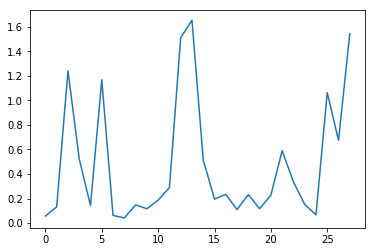

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


log_dir = "trained_models/saved_pose_model2"
file_pose_loss = np.loadtxt(log_dir+"/loss_pose.txt")
plt.plot(file_pose_loss)